In [1]:
%env CUDA_VISIBLE_DEVICES=-1

env: CUDA_VISIBLE_DEVICES=-1


In [2]:
%autosave 180
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

Autosaving every 180 seconds


In [3]:
import pylab as plt
import numpy as np
from pylab import *
from tqdm import tqdm_notebook as tqdm
from scipy.io import loadmat


In [4]:
from keras.layers import Input, Dense, Lambda, Flatten, Concatenate, Conv1D
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K
from functools import partial
import tensorflow as tf
from keras.engine.topology import Layer

from keras import backend as K
from keras.engine.topology import Layer
import numpy as np
import keras
from IPython.display import clear_output
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss", marker='*')
        plt.plot(self.x, self.val_losses, label="val_loss", marker='*')
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

Using TensorFlow backend.


In [58]:
class GradientLayer1D(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(GradientLayer1D, self).__init__(**kwargs)

    def build(self, input_shapes):
        super(GradientLayer1D, self).build(input_shapes)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
        
    def call(self, tensors):
        u, input_x, input_v = tensors
        
        #[0] - keras specifics
        dudx = tf.gradients(u, input_x)[0]
        
        val = K.square(dudx) - input_v
        return  val

def init_model1D(nX=1):
    
    input_x = Input(shape=(nX,), name='input_x')
    input_v = Input(shape=(nX,), name='input_v')
    tensors = [input_x, input_v]
    
    nh = 32
    
    activation = 'tanh'
#     activation = 'softplus'
#     activation = 'relu'
#     activation = 'sigmoid'
#     activation = 'relu'
#     activation = 'softmax'

    x = input_x
    x = Dense(nh, activation=activation)(x)
    x = Dense(nh, activation=activation)(x)


    output = Dense(nX, activation=None)(x)
    output = Lambda(lambda x: K.abs(x), name='time')(output)
    
    
    gradient = GradientLayer1D(1, name='loss')([output] + tensors)
    
    model_time = Model(inputs=tensors, outputs=output)
    model_loss = Model(inputs=tensors, outputs=gradient)
    
    def custom_objective(y_true, y_pred):
        return keras.losses.mean_squared_error(y_pred*0, y_pred) + K.sum(K.square(y_true*output))

    optimizer = Adam(lr=0.001)
    
    model_loss.compile(
        optimizer=optimizer, 
        loss=custom_objective
    )
    return model_loss, model_time

### 1D

In [59]:
ndim = 1001
xc = 800
input_x = np.linspace(0, 1, ndim) 
dx = np.diff(input_x)[1]

input_x = input_x[..., None]
input_v = input_x*0 + 1

input_w = input_x*0
input_w[xc] = 1

true_u = np.abs(input_x - input_x[xc])

data = dict(
    input_x=input_x,
    input_v=input_v,
)

In [60]:
model_loss, model_time = init_model1D(nX=1)

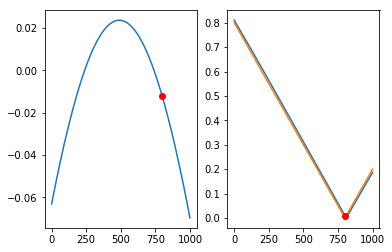

In [61]:
for i in range(20):
    model_loss.fit(
        data, 
        input_w,
        batch_size=32,
        epochs=1,
        shuffle=True,
        callbacks=[],
    )
    
    clear_output(wait=True)
    
    plt.subplot(121)
    pred = model_loss.predict(data)
    pred = np.squeeze(pred)
    plt.plot(np.squeeze(pred))
    plt.plot(xc, pred[xc], 'or')

    plt.subplot(122)
    u = model_time.predict(data)
    u = np.squeeze(u)
    plt.plot(u)
    plt.plot(true_u)
    # plt.plot(true_u)
    plt.plot(xc, u[xc], 'or')
    plt.show()

